# Titanic Survival Prediction

In this project we will use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.
We will work with the datasets from [Kaggle](https://www.kaggle.com/competitions/titanic/data).

In [187]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import rcParams
from matplotlib.cm import rainbow
import matplotlib.pyplot as plt

### Load the data

The data has been split into two groups:

* training set (train.csv)
* test set (test.csv)

The data contains the following features:

* survival: 0 = No, 1 = Yes
* pclass: Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
* sex	
* Age: Age in years	
* sibsp: # of siblings / spouses aboard the Titanic	
* parch: # of parents / children aboard the Titanic	
* ticket: Ticket number	
* fare: Passenger fare	
* cabin: Cabin number	
* embarked: Port of Embarkation

In [188]:
data = pd.read_csv('train.csv')
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Understanding the data

Now, we can use visualizations to better understand our data and then look at any processing we might want to do.

In [189]:
# Some information about the dataset
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


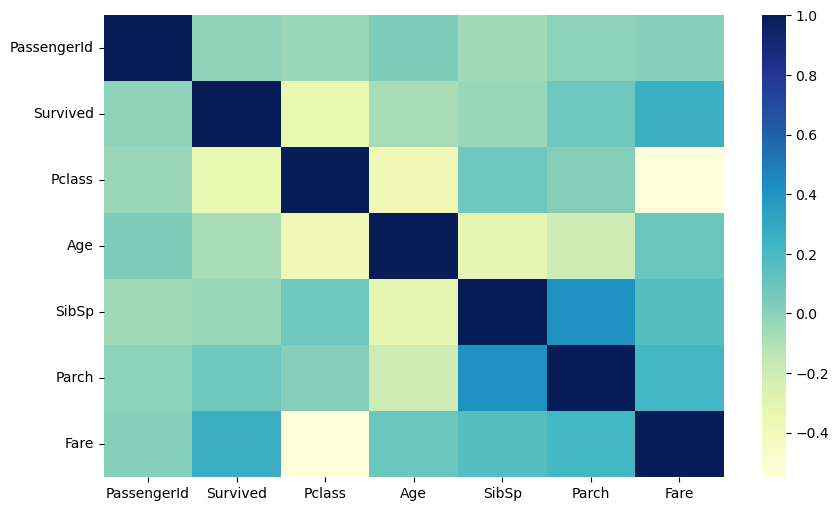

In [190]:
# Heatmap plot to see correlation between data
rcParams['figure.figsize'] = 10, 6
sns.heatmap(data.corr(), cmap='YlGnBu')
plt.show()

Some considerations:

From the heatmap we can see that for example **Pclass** is negative correlated with the **Survived** value which intuitively makes makes sense because wealthy people were more likely to save themselves during the disaster. This is also demonstrated by the correlation between the amount paid for the ticker, **fare**, and the **Survived** value.

### Splitting the data

We will split the data into test set and train set. We are going to use `StratifiedShuffleSplit` to have a similar distribution on test data and train data for features that have high importance.

In [191]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(data, data[['Survived', 'Pclass', 'Sex']]):
    strat_train_set = data.loc[train_indices]
    strat_test_set = data.loc[test_indices]

Let's check id the distribution are the same.

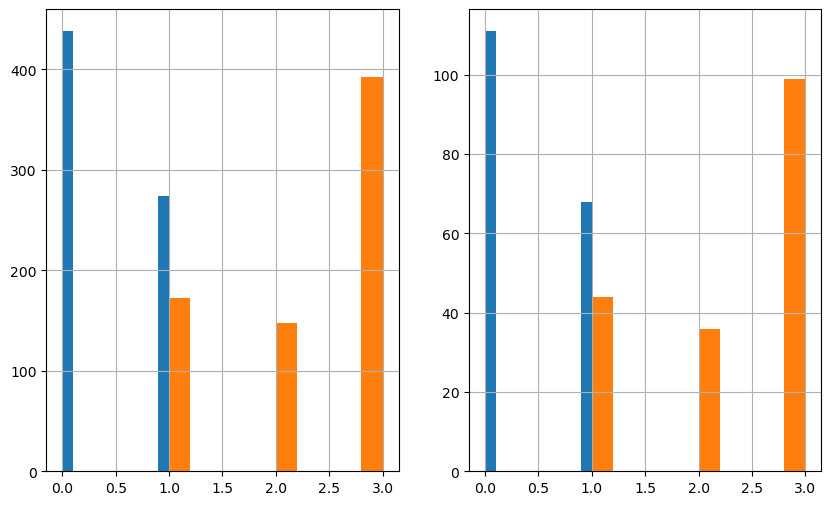

In [192]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.show()

In [193]:
# Check for missing data
strat_train_set.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            139
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          553
Embarked         1
dtype: int64

We can see that **Age** data is missing for a lot of people. In this case we cannot just drop them because otherwise we will lose a lot of data. So we impute them with estimators.

In [194]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy='mean')
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

### Encode categorical data

In [195]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        column_names = ['C', 'S', 'Q', 'N']
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        column_names = ['Female', 'Male']
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]  
        
        return X

### Drop useless features

In [196]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(['Embarked', 'Name', 'Ticket', 'Cabin', 'Sex', 'N'], axis=1, errors='ignore')

### Build the pipeline

In [197]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('ageimputer', AgeImputer()),
                     ('featureencoder', FeatureEncoder()),
                     ('featuredropper', FeatureDropper())])

In [198]:
# Pass the data through the pipeline 
strat_train_set = pipeline.fit_transform(strat_train_set)
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
357,358,0,2,38.000000,0,0,13.0000,0.0,0.0,1.0,1.0,0.0
858,859,1,3,24.000000,0,3,19.2583,1.0,0.0,0.0,1.0,0.0
302,303,0,3,19.000000,0,0,0.0000,0.0,0.0,1.0,0.0,1.0
453,454,1,1,49.000000,1,0,89.1042,1.0,0.0,0.0,0.0,1.0
268,269,1,1,58.000000,0,1,153.4625,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
792,793,0,3,30.069372,8,2,69.5500,0.0,0.0,1.0,1.0,0.0
747,748,1,2,30.000000,0,0,13.0000,0.0,0.0,1.0,1.0,0.0
545,546,0,1,64.000000,0,0,26.0000,0.0,0.0,1.0,0.0,1.0
247,248,1,2,24.000000,0,2,14.5000,0.0,0.0,1.0,1.0,0.0


In [199]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 357 to 533
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


### Feature Scaling

In [200]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis = 1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

## Build the Model

### Random Forest Classifier

In [201]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier()

# Here we can add different values to try to find the best combinations
param_grid = [
    {'n_estimators':[10], 'max_depth':[5], 'min_samples_split':[2]}
]

In [202]:
grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [5], 'min_samples_split': [2],
                          'n_estimators': [10]}],
             return_train_score=True, scoring='accuracy')

In [203]:
final_classifier = grid_search.best_estimator_
final_classifier

RandomForestClassifier(max_depth=5, n_estimators=10)

### Run model on Test set

In [204]:
# Pass data through the pipeline
strat_test_set = pipeline.fit_transform(strat_test_set)

# Feature Scaling 
X_test = strat_test_set.drop(['Survived'], axis = 1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [205]:
final_classifier.score(X_data_test, y_data_test)

0.8324022346368715

## Test model on the whole Train Test

In [206]:
# Pass data through the pipeline
data = pipeline.fit_transform(data)

# Feature Scaling 
X = strat_test_set.drop(['Survived'], axis = 1)
y = strat_test_set['Survived']

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.to_numpy()

In [207]:
prod_classifier = RandomForestClassifier()

# Here we can add different values to try to find the best combinations
param_grid = [
    {'n_estimators':[10], 'max_depth':[5], 'min_samples_split':[3]}
]

In [208]:
grid_search = GridSearchCV(prod_classifier, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X, y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [5], 'min_samples_split': [3],
                          'n_estimators': [10]}],
             return_train_score=True, scoring='accuracy')

In [209]:
prod_final_classifier = grid_search.best_estimator_
prod_final_classifier

RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=10)

## Run the production classifier on Test Data

In [210]:
final_test_data = pd.read_csv('test.csv')

In [211]:
# Pass data through the pipeline
final_test_data = pipeline.fit_transform(final_test_data)

In [212]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Female       418 non-null    float64
 10  Male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.0 KB


In [213]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method='ffill')

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

In [214]:
prediction = prod_final_classifier.predict(X_data_final_test)

In [218]:
final_df = pd.DataFrame(X_final_test['PassengerId'])
final_df['Survived'] = prediction
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [219]:
final_df.to_csv('predictions_titanic.csv')